# Load ads

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

# from housing_crawler.utils import save_file, get_file, get_grid_polygons_all_cities
from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters
from housing_crawler.utils import standardize_features, return_significative_coef


from config.config import ROOT_DIR
from housing_crawler.params import dict_city_number_wggesucht

In [2]:
ads_feat_df = get_processed_ads_table()
list(ads_feat_df.columns)

===> Loaded ads_OSM.csv locally


/home/carlo/code/chvieira2/housing_crawler/housing_crawler/utils.py:35: DtypeWarning: Columns (29,31,33,34,35,37,42,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path)


['id',
 'url',
 'commercial_landlord',
 'title',
 'price_euros',
 'size_sqm',
 'available_rooms',
 'capacity',
 'available_spots_wg',
 'male_flatmates',
 'female_flatmates',
 'diverse_flatmates',
 'published_on',
 'published_at',
 'address',
 'city',
 'crawler',
 'latitude',
 'longitude',
 'available_from',
 'available_to',
 'details_searched',
 'cold_rent_euros',
 'mandatory_costs_euros',
 'extra_costs_euros',
 'transfer_costs_euros',
 'deposit',
 'zip_code',
 'home_total_size',
 'smoking',
 'wg_possible',
 'building_type',
 'building_floor',
 'furniture',
 'kitchen',
 'heating',
 'public_transport_distance',
 'parking',
 'schufa_needed',
 'type_offer_simple',
 'min_age_flatmates',
 'max_age_flatmates',
 'gender_searched',
 'min_age_searched',
 'max_age_searched',
 'construction_year',
 'energy_certificate',
 'energy_usage',
 'energy_efficiency_class',
 'heating_energy_source',
 'number_languages',
 'internet_speed',
 'toilet',
 'internet_dsl',
 'internet_wlan',
 'internet_flatrate',


In [3]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

In [4]:
# Percentage missing values per column
(ads_feat_df.isnull().sum().sort_values(ascending=False)/len(ads_feat_df)*100)[0:30]

energy_usage                 98.392174
energy_efficiency_class      98.038806
toilet                       97.831604
energy_certificate           97.364194
construction_year            95.936265
heating_energy_source        94.795850
kitchen                      94.591860
internet_speed               93.388801
transfer_costs_euros         89.882425
heating                      86.022680
home_total_size              85.619519
max_age_flatmates            85.134441
smoking                      84.644544
min_age_flatmates            83.929776
extra_costs_euros            83.698481
parking                      81.857753
furniture                    79.851585
mandatory_costs_euros        76.457644
building_type                76.258473
public_transport_distance    75.373446
deposit                      74.967073
building_floor               73.462045
zip_code                     70.496964
languages_deutsch            70.443959
extras_keller                70.443959
extras_dachboden         

# Creating WG, single-room and multi-room dataframes

In [5]:
wg_df = ads_feat_df.query('type_offer_simple == "WG"').reset_index().drop(columns=['index'])

singleroom_df = ads_feat_df.query('type_offer_simple == "Single-room flat"').reset_index().drop(columns=['index'])

flathouse_df = ads_feat_df.query('(type_offer_simple == "Apartment")').reset_index().drop(columns=['index'])

# Linear model WG

In [6]:
wg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45734 entries, 0 to 45733
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 49.9+ MB


In [22]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'#'price_per_sqm'

selected_num_features = [
            'size_sqm',
#         'home_total_size',
#         'available_rooms',
        'capacity',
#         'available_spots_wg',

        'days_available',
#         'sin_published_at',
#         'cos_published_at',
        'sin_day_week_int',
        'cos_day_week_int',
    
# Values
#         'cold_rent_euros',
#         'mandatory_costs_euros',
#         'extra_costs_euros',
#         'deposit',
#         'transfer_costs_euros',
#         'price_per_sqm',

# Flatmates
        'male_flatmates',
        'female_flatmates',
        'diverse_flatmates',
#         'min_age_flatmates',
#         'max_age_flatmates',
    
# Person searched
        'min_age_searched',
        'max_age_searched',
    
# Details
    
        'smoking_numerical',
        'furniture_numerical',
#       'kitchen_numerical',
        'public_transport_distance',

    
# WG only
        'number_languages',
        
#         'internet_speed',
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            
        'rental_length_term',
    
# Person searched
        'gender_searched',
        'age_category_searched',
    
# Details
    
        'schufa_needed',
#         'wg_possible',
    
#         'smoking',
        'building_type',
        'building_floor',
#         'furniture',
#         'kitchen',
#         'heating',
#         'parking',
    
        'tv_kabel',
        'tv_satellit',
    
        'shower_type_badewanne',
        'shower_type_dusche',
    
        'floor_type_dielen',
        'floor_type_parkett',
        'floor_type_laminat',
        'floor_type_teppich',
        'floor_type_fliesen',
        'floor_type_pvc',
        'floor_type_fußbodenheizung',
    
        'extras_waschmaschine',
        'extras_spuelmaschine',
        'extras_terrasse',
        'extras_balkon',
        'extras_garten',
#         'extras_gartenmitbenutzung',
        'extras_keller',
        'extras_aufzug',
        'extras_haustiere',
        'extras_fahrradkeller',
        'extras_dachboden',
    
# WG only
        'languages_deutsch',
        'languages_englisch',
    
        'wg_type_studenten',
        'wg_type_keine_zweck',
        'wg_type_maenner',
        'wg_type_business',
        'wg_type_wohnheim',
        'wg_type_vegetarisch_vegan',
        'wg_type_alleinerziehende',
        'wg_type_funktionale',
        'wg_type_berufstaetigen',
        'wg_type_gemischte',
        'wg_type_mit_kindern',
        'wg_type_verbindung',
        'wg_type_lgbtqia',
        'wg_type_senioren',
        'wg_type_inklusive',
        'wg_type_wg_neugruendung',
    
        'internet_dsl',
        'internet_wlan',
        'internet_flatrate'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = wg_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45734 entries, 0 to 45733
Data columns (total 97 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price_euros                     45734 non-null  float64
 1   size_sqm                        45734 non-null  float64
 2   capacity                        45734 non-null  float64
 3   days_available                  45734 non-null  int64  
 4   sin_day_week_int                45734 non-null  float64
 5   cos_day_week_int                45734 non-null  float64
 6   male_flatmates                  45734 non-null  float64
 7   female_flatmates                45734 non-null  int64  
 8   diverse_flatmates               45734 non-null  float64
 9   min_age_searched                13077 non-null  float64
 10  max_age_searched                13077 non-null  float64
 11  smoking_numerical               13077 non-null  float64
 12  furniture_numerical             

In [23]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

(4556, 97)

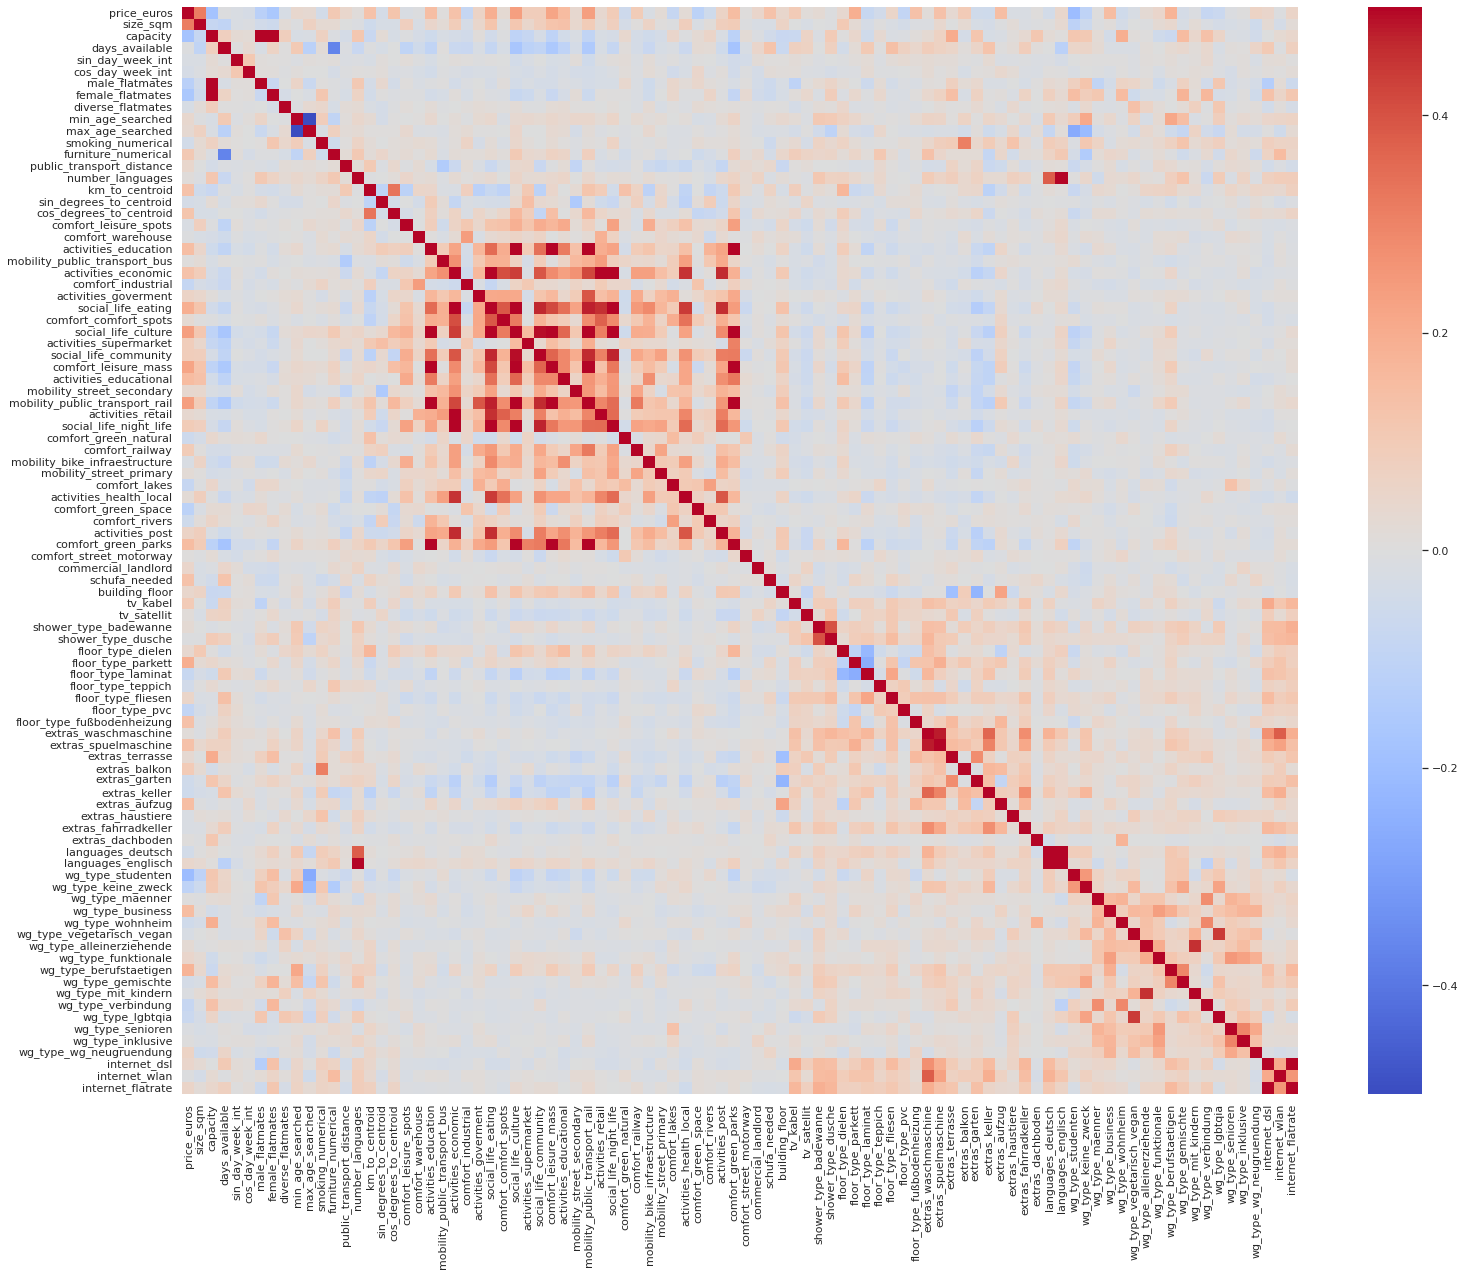

In [24]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 20))

data_corr = df_city.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [26]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
309,days_available,mobility_public_transport_rail,-0.149371
3039,mobility_public_transport_rail,days_available,-0.149371
2763,comfort_leisure_mass,days_available,-0.159546
306,days_available,comfort_leisure_mass,-0.159546
644,female_flatmates,price_euros,-0.160320
7,price_euros,female_flatmates,-0.160320
2487,social_life_culture,days_available,-0.170155
303,days_available,social_life_culture,-0.170155
321,days_available,comfort_green_parks,-0.177529
4143,comfort_green_parks,days_available,-0.177529


In [27]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
32,mobility_public_transport_rail,4.31
1,capacity,4.20
26,social_life_culture,3.88
24,social_life_eating,3.52
6,female_flatmates,2.99
21,activities_economic,2.84
29,comfort_leisure_mass,2.71
8,min_age_searched,2.54
9,max_age_searched,2.50
5,male_flatmates,2.46


In [28]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_euros   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     36.75
Date:                Tue, 30 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:56:16   Log-Likelihood:                -28011.
No. Observations:                4556   AIC:                         5.633e+04
Df Residuals:                    4404   BIC:                         5.730e+04
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        416.2208     59.613      6.982      0.000     299.349     533.093
C(city)[Berlin]                        556.4225     58.302      9.544      0.000     442.121     670.724
C(city)[Bonn]                          472.3992     59.308      7.965      0.000     356.125     588.673
C(city)[Bremen]                        427.8833     58.976      7.255      0.000     312.260     543.507
C(city)[Darmstadt]                     463.5203     59.445      7.797      0.000     346.978     580.062
C(city)[Dresden]                       338.6311     59.098      5.730      0.000     222.769     454.493
C(city)[Frankfurt am Main]             547.1519     58.736      9.315      0.000     432.000     662.303
C(city)[Göttingen]                     396.7066     59.166      6.705      0.000     280.711     512.702
C(city)[Hamburg]                       649.8149     61.313     10.598      0.000     529.611     770.019
C(city)[Hannover]                      414.9594     59.102      7.021      0.000     299.091     530.828
C(city)[Heidelberg]                    474.6176     59.500      7.977      0.000     357.969     591.267
C(city)[Karlsruhe]                     429.7641     58.973      7.288      0.000     314.148     545.380
C(city)[Kiel]                          376.0177     60.179      6.248      0.000     258.036     493.999
C(city)[Köln]                          515.3037     58.553      8.801      0.000     400.509     630.098
C(city)[Leipzig]                       337.9559     58.527      5.774      0.000     223.214     452.698
C(city)[Mainz]                         463.4793     59.528      7.786      0.000     346.774     580.184
C(city)[Mannheim]                      429.8413     59.947      7.170      0.000     312.315     547.367
C(city)[München]                       674.0474     58.540     11.514      0.000     559.280     788.814
C(city)[Münster]                       410.1853     59.363      6.910      0.000     293.804     526.566
C(city)[Nürnberg]                      439.0739     59.605      7.366      0.000     322.219     555.929
C(city)[Regensburg]                    421.0043     59.721      7.049      0.000     303.920     538.088
C(city)[Stuttgart]                     527.9931     58.487      9.027      0.000     413.328     642.658
C(city)[Tübingen]                      478.6754     61.403      7.796      0.000     358.294     599.057
C(city)[Würzburg]                      414.9283     59.639      6.957      0.000     298.007     531.850
C(commercial_landlord)[T.1.0]           42.8650     24.618      1.741      0.082      -5.398      91.128
C(rental_length_term)[T.<270days]        0.6174      8.698      0.071      0.943     -16.434      17.669
C(rental_length_term)[T.<365days]     

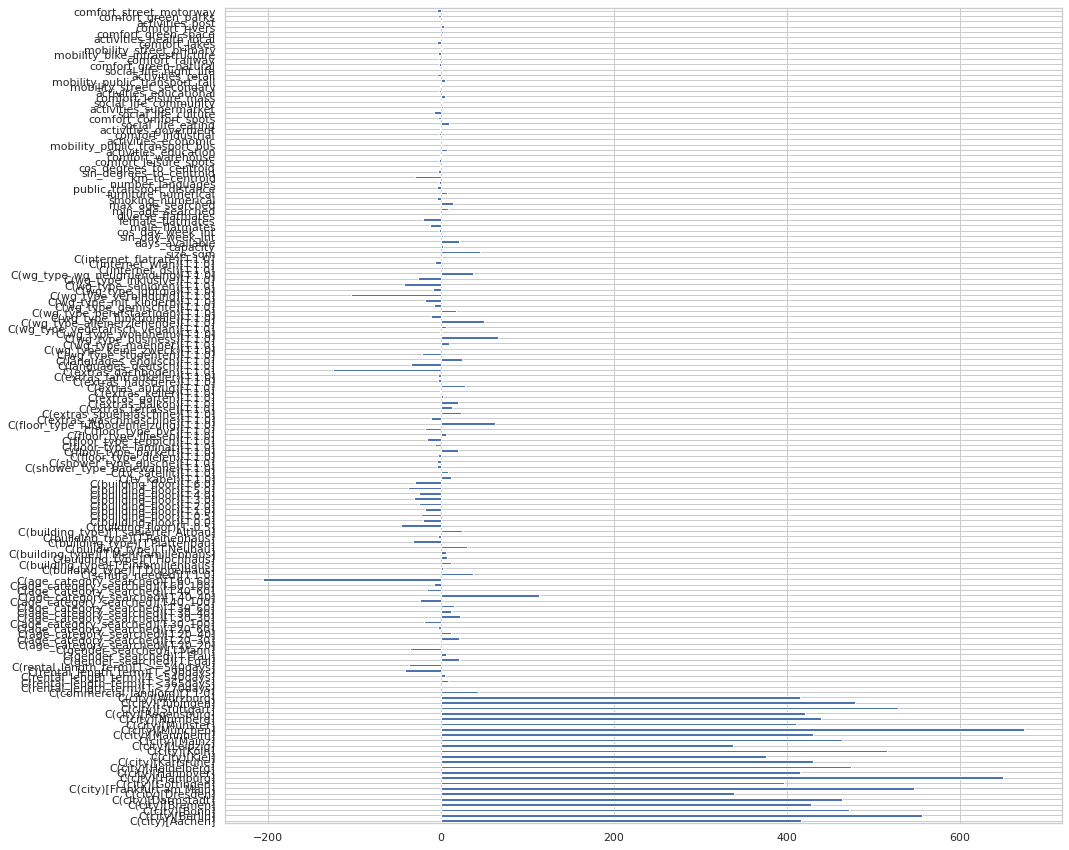

In [29]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

RMSE: 113.20102723207636
RMSE base model: 170.18396982748504


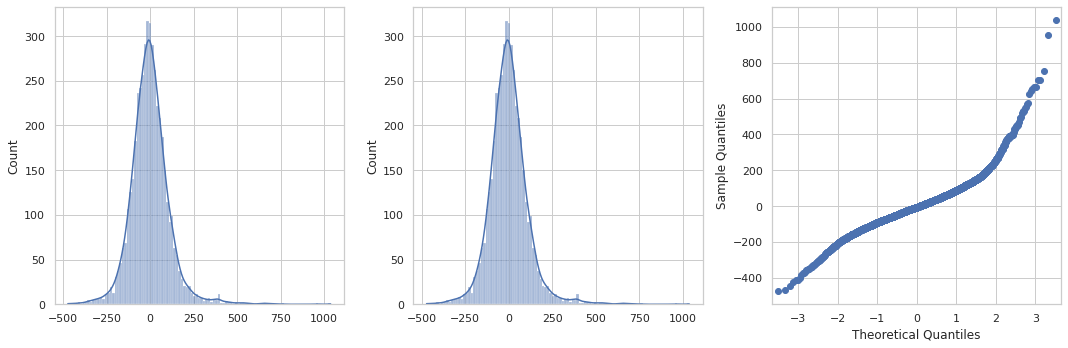

In [30]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

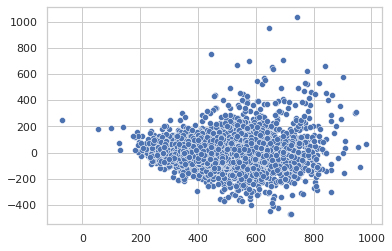

In [31]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                            p_value        coef
variable                                                       
C(city)[München]                       3.013707e-30  674.047410
C(city)[Hamburg]                       6.210833e-26  649.814934
C(city)[Berlin]                        2.214907e-21  556.422487
C(city)[Frankfurt am Main]             1.869109e-20  547.151948
C(city)[Stuttgart]                     2.572985e-19  527.993113
C(city)[Köln]                          1.922607e-18  515.303700
C(city)[Tübingen]                      7.945490e-15  478.675431
C(city)[Heidelberg]                    1.898726e-15  474.617622
C(city)[Bonn]                          2.083815e-15  472.399248
C(city)[Darmstadt]                     7.828694e-15  463.520317
C(city)[Mainz]                         8.570531e-15  463.479254
C(city)[Nürnberg]                      2.081179e-13  439.073939
C(city)[Mannheim]                      8.731217e-13  429.841296
C(city)[Karlsruhe]                     3

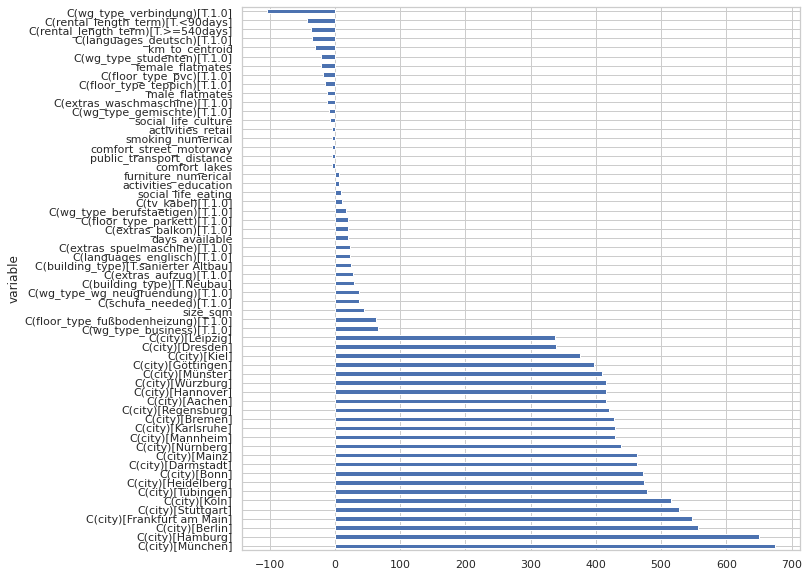

In [32]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Apartment

In [ ]:
flathouse_df.info()

In [ ]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
            'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

#             'building_floor',
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
#             'smoking',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
            'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
#             'gender_searched',
                         
#             'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = flathouse_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

In [ ]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

In [ ]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [ ]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

In [ ]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

In [ ]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

In [ ]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

In [ ]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

In [ ]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

In [ ]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');

# Linear model Single-room flats

In [ ]:
singleroom_df.info()

In [ ]:
# define columns to work
features = [
    'km_to_centroid',
    'sin_degrees_to_centroid',
    'cos_degrees_to_centroid',
    
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]

target = 'price_euros'

selected_num_features = [
    'size_sqm',
#             'days_available',
#             'available_rooms',
#             'capacity',
#             'male_flatmates',
#             'female_flatmates',
#             'diverse_flatmates',
    
#             'cold_rent_euros',
#             'mandatory_costs_euros',
#             'extra_costs_euros',
            'transfer_costs_euros',
#             'deposit',

            'building_floor',
            'furniture',
            'kitchen',
#             'public_transport_distance',
#             'home_total_size',
            'smoking',
    
#             'min_age_flatmates',
#             'max_age_flatmates',
    
#             'min_age_searched',
#             'max_age_searched',
    
#             'number_languages',
    
#             'sin_published_at',
#             'cos_published_at',
#             'sin_day_week_int',
#             'cos_day_week_int'
    
] + features
selected_cat_features = ['city',
                         'commercial_landlord',
            'rental_length_term',
#             'energy',
#             'wg_possible',
            'building_type',
#             'shower_type',
#             'floor_type',
#             'heating',
#             'internet',
#             'parking',
                         
            'schufa_needed',
                         
            'extras_waschmaschine',
            'extras_spuelmaschine',
            'extras_terrasse',
            'extras_balkon',
            'extras_garten',
#             'extras_gartenmitbenutzung',
            'extras_keller',
            'extras_aufzug',
            'extras_haustiere',
            'extras_fahrradkeller',
            'extras_dachboden',
                         
#             'languages_deutsch',
#             'languages_englisch',
                         
#             'wg_type_studenten',
#             'wg_type_keine_zweck',
#             'wg_type_maenner',
#             'wg_type_business',
#             'wg_type_wohnheim',
#             'wg_type_vegetarisch_vegan',
#             'wg_type_alleinerziehende',
#             'wg_type_funktionale',
#             'wg_type_berufstaetigen',
#             'wg_type_gemischte',
#             'wg_type_mit_kindern',
#             'wg_type_verbindung',
#             'wg_type_lgbtqia',
#             'wg_type_senioren',
#             'wg_type_inklusive',
#             'wg_type_wg_neugruendung',
                         
            'tv_kabel',
            'tv_satellit',
                         
            'gender_searched',
                         
            'age_category_searched'
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
df_zscored = singleroom_df[all_columns#+['city']
                     ].copy()

df_zscored.info()

In [ ]:
df_zscored = df_zscored.dropna(axis=0)
# z-scoring columns
df_zscored = standardize_features(df_zscored, columns_to_zscore)

# Filter table if needed
df_city = df_zscored#[df_zscored['city'] == 'Leipzig']
df_city.shape

In [ ]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 12.5))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-0.5, vmax=0.5);

In [ ]:
data_corr = df_city.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

In [ ]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

In [ ]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

In [ ]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model_city.params[0:].plot(kind='barh');

In [ ]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_euros'])]*len(y_pred)
y_true = df_city['price_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(-residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(-residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

In [ ]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

In [ ]:
df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');